In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions

In [2]:
#Read raw data
raw_data = pd.read_excel('Final Project Data.xlsx',header = 1).set_index('Customer ID')
#split in to train and test 
train_data = raw_data.loc[:,'2019-1':'2019-9']
test_data = raw_data.loc[:,'2019-10':]

#### MARKOV CHAIN

In [3]:
#MarkovChain class is quoted from stackoverflow.com
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

def transition_matrix_creater(train_data): 
    """
    This function creates transition matrices of each individual by using their switching pattern.
    input: dataframe with multiple rows(customer transactions) 
    output: transition probabilities of each consumer in a list of matrices
    """
    transition_matrix_list = []
    for row_num in range(0, train_data.shape[0]):
        a,b,c,d = 0,0,0,0
        for months in range(0, len(train_data.columns)-1):
            if train_data.iloc[row_num,months] == 1 and train_data.iloc[row_num,months+1] == 1:
                a+=1
            elif train_data.iloc[row_num,months] == 1 and train_data.iloc[row_num,months+1] == 0:
                b+=1
            elif train_data.iloc[row_num,months] == 0 and train_data.iloc[row_num,months+1] == 0:
                c+=1
            elif train_data.iloc[row_num,months] == 0 and train_data.iloc[row_num,months+1] == 1:
                d+=1
        if a+b == 0:
            transition_matrix = [[0.5, 0.5], [d/(c+d),c/(c+d)]]
        elif c+d == 0:
            transition_matrix = [[a/(a+b), b/(a+b)], [0.5,0.5]]
        else: 
            transition_matrix = [[a/(a+b), b/(a+b)], [d/(c+d),c/(c+d)]]
        #print(row_num) if row_num % 1000 == 0 else 0
        transition_matrix_list.append(transition_matrix)
    return transition_matrix_list

def make_predictions(train_data, transition_matrices, n_of_periods):
    """
    This function uses train data, MarkovChain class and the output of transition_matrix_creater to generate expected pattern.
    
    """
    preds = []
    for i in range(0, len(transition_matrices)):
        transition_matrix = transition_matrices[i]
        row_chain = MarkovChain(transition_matrix=transition_matrix, states=['1', '0'])
        preds.append(row_chain.generate_states(current_state=str(train_data.iloc[i,-1]), no=n_of_periods))
    return preds

In [4]:
#Create list of transition matrices 
transition_matrices = transition_matrix_creater(train_data)
#Generate predictions
preds = make_predictions(train_data, transition_matrices,5)

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
churn_pred = []
for i in range(0,5):
    print(test_data.columns[i])
    tn, fp, fn, tp = confusion_matrix(np.array(test_data.iloc[:,i]).tolist(), [int(a) for a in np.array(preds).T.tolist()[i]]).ravel()
    churn_pred.append(fp+tp)
    print("\n confusion_matrix\n")
    print(confusion_matrix(np.array(test_data.iloc[:,i]).tolist(), [int(a) for a in np.array(preds).T.tolist()[i]]))
    print("\n Accuracy Score\n")
    print(accuracy_score(np.array(test_data.iloc[:,i]).tolist(), [int(a) for a in np.array(preds).T.tolist()[i]]))
    print("------------------------")

2019-10

 confusion_matrix

[[7619 1263]
 [ 750  368]]

 Accuracy Score

0.7987
------------------------
2019-11

 confusion_matrix

[[7797 1181]
 [ 647  375]]

 Accuracy Score

0.8172
------------------------
2019-12

 confusion_matrix

[[7760 1240]
 [ 617  383]]

 Accuracy Score

0.8143
------------------------
2020-1

 confusion_matrix

[[7947 1200]
 [ 514  339]]

 Accuracy Score

0.8286
------------------------
2020-2

 confusion_matrix

[[7894 1262]
 [ 486  358]]

 Accuracy Score

0.8252
------------------------


This confusion matrices shows that, accuracy would be high. However, sensitivity and specificity metrics indicate a poor model.

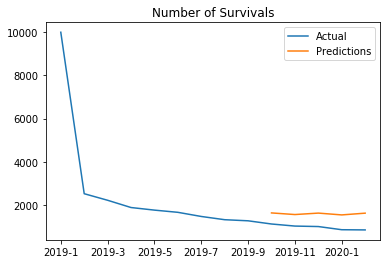

In [6]:
predictions = pd.DataFrame(churn_pred,index = ['2019-10', '2019-11','2019-12','2020-1','2020-2'])

real_data = pd.DataFrame(raw_data.drop('Unnamed: 10', axis = 1).sum()).rename({0:'Actual'}, axis = 1)

real_data['Predictions'] = predictions

ax = real_data.plot()
ax.set_title('Number of Survivals')
plt.show()

Even Markov Chain performed poorly for this dataset.

### GEOMETRIC

Log-likelood of p

In [7]:
cust_df = pd.DataFrame(train_data.sum(), columns = ['Cust'])
cust_df

,Cust
2019-1,10000
2019-2,2521
2019-3,2217
2019-4,1881
2019-5,1761
2019-6,1659
2019-7,1467
2019-8,1317
2019-9,1266


In [8]:
def GeoLL(theta,sData):
    N=len(sData)
    nCust=sData.Cust.values
    ####
    nLost=np.zeros(N)
    nLost[0]=0
    for k in range(1,N):
        nLost[k]= nCust[k-1]-nCust[k]
    ####
    P_die=np.zeros(N)
    for k in range(1,N):
        P_die[k]= theta*((1-theta)**(k-1))
    ####
    S_t=np.zeros(N)
    S_t[0]=1
    for k in range(1,N):
        S_t[k]= S_t[k-1]-P_die[k]
    ####
    LL=0
    for k in range(1,N):
        LL+= np.log(P_die[k])* nLost[k]
    LL+=np.log(S_t[-1])* nCust[-1]
    return -LL

In [9]:
initial_guess = [0.5]
bnds = ((0.001, 0.999),)
res= optimize.minimize(GeoLL,initial_guess,args=cust_df,bounds=bnds)
res.x

array([0.38268413])

Our log-likelihood search result states that maximum likelihood of p = 0.3826

In [10]:
prob = res.x
N=14
P_die=np.zeros(N)
for k in range(1,N):
    P_die[k]= prob*((1-prob)**(k-1))
S_t=np.zeros(N)
S_t[0]=1
for k in range(1,N):
    S_t[k]= S_t[k-1]-P_die[k]
    
predictions = (S_t*10000).tolist()

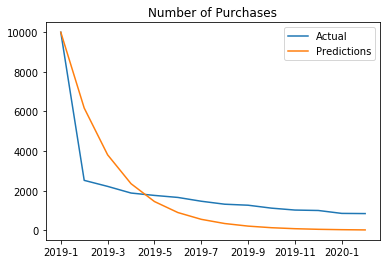

In [11]:
predictions = pd.DataFrame(predictions,index = raw_data.columns.drop( 'Unnamed: 10'))

real_data = pd.DataFrame(raw_data.iloc[:,:].drop('Unnamed: 10', axis = 1).sum()).rename({0:'Actual'}, axis = 1)

real_data['Predictions'] = predictions

ax = real_data.plot()
ax.set_title('Number of Purchases')
plt.show()

Our model underpredicted the number of purchases

### BETAGEOMETRIC

In [12]:
cust_df

,Cust
2019-1,10000
2019-2,2521
2019-3,2217
2019-4,1881
2019-5,1761
2019-6,1659
2019-7,1467
2019-8,1317
2019-9,1266


In [13]:
def BetaGeoLL(params, sData):
    gamma, delta= params
    N=len(sData)
    nCust=sData.Cust.values
    ####
    nLost=np.zeros(N)
    nLost[0]=0
    for k in range(1,N):
        nLost[k]= nCust[k-1]-nCust[k]
    ####
    P_die=np.zeros(N)
    P_die[1]=gamma/(gamma+delta)
    for k in range(2,N):
        P_die[k]= P_die[k-1]*(delta+k-2)/(gamma+delta+k-1)
    ####
    S_t=np.zeros(N)
    S_t[0]=1
    for k in range(1,N):
        S_t[k]= S_t[k-1]-P_die[k]
    ####
    LL=0
    for k in range(1,N):
        LL+= np.log(P_die[k])* nLost[k]
    LL+=np.log(S_t[-1])* nCust[-1]
    return -LL

In [14]:
#MLE parameter search 
initial_guess = [1, 1]
bnds = ((0.001, None), (0.001, None))
res= optimize.minimize(BetaGeoLL,initial_guess,args=(cust_df),bounds=bnds)
res.x

array([0.28690087, 0.09744855])

In [15]:
gamma, delta= res.x
N=14
####
P_die=np.zeros(N)
P_die[1]=gamma/(gamma+delta)
for k in range(2,N):
    P_die[k]= P_die[k-1]*(delta+k-2)/(gamma+delta+k-1)
####
S_t=np.zeros(N)
S_t[0]=1
for k in range(1,N):
    S_t[k]= S_t[k-1]-P_die[k]
predictions = (S_t*10000).tolist()

Survival

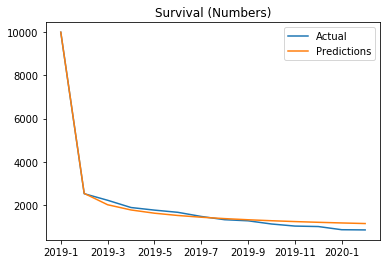

In [16]:
predictions = pd.DataFrame(predictions,index = raw_data.columns.drop( 'Unnamed: 10'))

real_data = pd.DataFrame(raw_data.iloc[:,:].drop('Unnamed: 10', axis = 1).sum()).rename({0:'Actual'}, axis = 1)

real_data['Predictions'] = predictions

ax = real_data.plot()
ax.set_title('Survival (Numbers)')
plt.show()

Retention

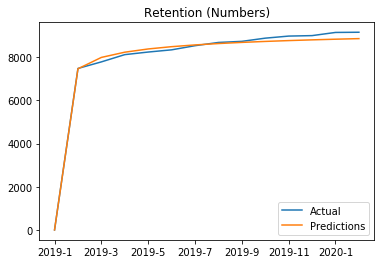

In [17]:
predictions_2 = 10000-predictions

real_data_2 = 10000-real_data
real_data_2['Predictions'] = predictions_2

ax = real_data_2.plot()
ax.set_title('Retention (Numbers)')
plt.show()

BetaGeometric model predicted next 5 months with a remarkable accuracy

### Pareto NBD

In [18]:
train_data2 = train_data.drop('2019-1', axis = 1)
frequency = train_data2.sum(axis=1)
recency = ((train_data2*[8,7,6,5,4,3,2,1]).replace({0:None}).min(axis=1)).fillna(0)
T_value = np.ones(10000)*8

In [19]:
nbd = ParetoNBDFitter()
nbd.fit(frequency, recency, T_value )

<lifetimes.ParetoNBDFitter: fitted with 10000 subjects, alpha: 2.19, beta: 30.31, r: 0.83, s: 3.98>

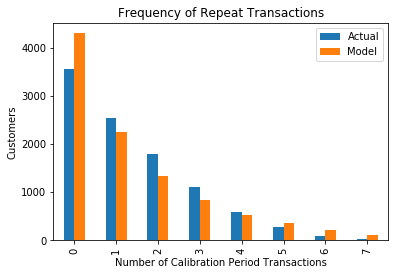

In [20]:
plot_period_transactions(nbd, max_frequency = 8)

Tracking transactions

In [21]:
#Train and test predictions of model
ex_trans_list = []
for i in range(1,14):
    trans = (nbd.expected_number_of_purchases_up_to_time(i)).sum()
    ex_trans_list.append(trans-sum(ex_trans_list))

#expected number of transactions
ex_trans_list = [10000]+[i*10000 for i in ex_trans_list]

,Actual,Predictions
2019-1,10000,10000.000000
2019-2,2521,3558.646195
2019-3,2217,3133.194956
2019-4,1881,2769.511002
2019-5,1761,2457.134015
2019-6,1659,2187.613990
2019-7,1467,1954.081448
2019-8,1317,1750.918334
2019-9,1266,1573.504053
2019-10,1118,1418.018061


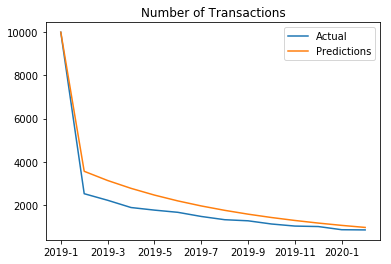

In [22]:
predictions = pd.DataFrame(ex_trans_list,index = raw_data.columns.drop( 'Unnamed: 10'))

real_data = pd.DataFrame(raw_data.iloc[:,:].drop('Unnamed: 10', axis = 1).sum()).rename({0:'Actual'}, axis = 1)

real_data['Predictions'] = predictions

display(real_data)

ax = real_data.plot()
ax.set_title('Number of Transactions')
plt.show()

Tracking Cumulative Transactions

In [23]:
#Train and test predictions of model
cum_trans_list = []
for i in range(1,14):
    trans = (nbd.expected_number_of_purchases_up_to_time(i)).sum()
    cum_trans_list.append(trans)

#expected number of transactions
cum_trans_list = [10000]+[i*10000+10000 for i in cum_trans_list]

,Actual,Predictions
2019-1,10000,10000.000000
2019-2,12521,13558.646195
2019-3,14738,16691.841151
2019-4,16619,19461.352153
2019-5,18380,21918.486168
2019-6,20039,24106.100157
2019-7,21506,26060.181606
2019-8,22823,27811.099940
2019-9,24089,29384.603993
2019-10,25207,30802.622054


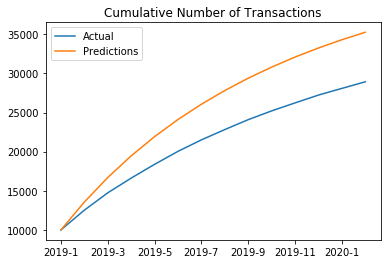

In [24]:
predictions = pd.DataFrame(cum_trans_list,index = raw_data.columns.drop( 'Unnamed: 10'))

real_data = pd.DataFrame(raw_data.iloc[:,:].drop('Unnamed: 10', axis = 1).sum().cumsum()).rename({0:'Actual'}, axis = 1)

real_data['Predictions'] = predictions

display(real_data)

ax = real_data.plot()
ax.set_title('Cumulative Number of Transactions')
plt.show()

Cumulative graph shows a more significant difference. However, point estimations look very accurate.